In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import os
import surfplot
import nibabel as nib
import h5py
import scipy.stats as stats
import sklearn.svm as svm
import sklearn
from neuromaps.datasets import fetch_fslr
from statsmodels.stats.multitest import fdrcorrection
%matplotlib inline


In [4]:
# Load parameters + data # data/data/glasser_data_glm_then_concat/glm_betas/sub-03/correct_ses5_task-interdmsctgABBA_run-02.csv
subj = 'sub-03'
runs = ['run-01', 'run-02', 'run-03', 'run-04', 'run-05']

sessions = ['ses1', 'ses2', 'ses3', 'ses4', 'ses5', 'ses6', 'ses7', 'ses8', 'ses9', 'ses10', 'ses11', 'ses12', 'ses13', 'ses14', 'ses15', 'ses16']
cwd = os.getcwd()

# Get the path of the parent directory
parent_dir = '/Users/xiaoxuan/Desktop/202406_fMRI/data/' # os.path.abspath(os.path.join(cwd, os.pardir))

basedir = parent_dir

datadir = parent_dir + subj + '/glm_betas/' + subj + "/glm_betas_all_possible_TR_betas/" + subj + "/"
glasser_atlas_str= basedir + 'Glasser_LR_Dense64k.dlabel.nii'
glasser_atlas = nib.load(glasser_atlas_str).get_fdata()[0].astype(int)
print(glasser_atlas.shape)
num_regions = 360

(64984,)


In [5]:
datadir

'/Users/xiaoxuan/Desktop/202406_fMRI/data/sub-03/glm_betas/sub-03/glm_betas_all_possible_TR_betas/sub-03/'

In [6]:
task_betas = {}
df_conditions = {} # 'task-dmsloc_run-01'
tasks = ['dmsloc','1backloc', '1backctg', '1backobj', 'ctxlco' , 'ctxcol', 
       'interdmsobjABAB', 'interdmslocABBA', 'interdmslocABAB',
       'interdmsctgABAB', 'interdmsobjABBA','interdmsctgABBA'] 


for task in tasks:
    for sess in sessions:
        for run in runs:
            try:
                print(datadir + 'normalizedglmmethod1_' + sess + '_' + 'task-' + task + '_' + run + '_betas.h5')
                h5f = h5py.File(datadir + 'normalizedglmmethod1_' + sess + '_' + 'task-' + task + '_' + run + '_betas.h5','r')
                print("correctly open")
                try: 
                    task_betas[task][sess][run] = h5f['betas'][:].copy()
                    df_conditions[task][sess][run] = pd.read_csv(datadir + 'glmmethod1_' + sess + '_' + 'task-' + task + '_' + run + '.csv')
                except Exception as e:
                    try:
                        task_betas[task][sess] = {}
                        task_betas[task][sess][run] = h5f['betas'][:].copy()
                        df_conditions[task][sess] = {}
                        df_conditions[task][sess][run] = pd.read_csv(datadir + 'glmmethod1_' + sess + '_' + 'task-' + task + '_' + run + '.csv')
                    except Exception as e:
                        task_betas[task] = {}
                        task_betas[task][sess] = {}
                        task_betas[task][sess][run] = h5f['betas'][:].copy()
                        df_conditions[task]= {}
                        df_conditions[task][sess] = {}
                        df_conditions[task][sess][run] = pd.read_csv(datadir + 'glmmethod1_' + sess + '_' + 'task-' + task + '_' + run + '.csv')
                h5f.close()
            except Exception as e:
                print(e)
                continue



/Users/xiaoxuan/Desktop/202406_fMRI/data/sub-03/glm_betas/sub-03/glm_betas_all_possible_TR_betas/sub-03/normalizedglmmethod1_ses1_task-dmsloc_run-01_betas.h5
correctly open
/Users/xiaoxuan/Desktop/202406_fMRI/data/sub-03/glm_betas/sub-03/glm_betas_all_possible_TR_betas/sub-03/normalizedglmmethod1_ses1_task-dmsloc_run-02_betas.h5
[Errno 2] Unable to synchronously open file (unable to open file: name = '/Users/xiaoxuan/Desktop/202406_fMRI/data/sub-03/glm_betas/sub-03/glm_betas_all_possible_TR_betas/sub-03/normalizedglmmethod1_ses1_task-dmsloc_run-02_betas.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
/Users/xiaoxuan/Desktop/202406_fMRI/data/sub-03/glm_betas/sub-03/glm_betas_all_possible_TR_betas/sub-03/normalizedglmmethod1_ses1_task-dmsloc_run-03_betas.h5
[Errno 2] Unable to synchronously open file (unable to open file: name = '/Users/xiaoxuan/Desktop/202406_fMRI/data/sub-03/glm_betas/sub-03/glm_betas_all_possible_TR_betas/sub-03/normalizedglmmethod

### isolate first delay betas

In [7]:
# only run this once!
filtered_task_betas_encoding = task_betas.copy()
filtered_task_df_encoding = df_conditions.copy()

filtered_task_betas_delay = task_betas.copy()
filtered_task_df_delay = df_conditions.copy()

for task in task_betas.keys():
    for sess in task_betas[task].keys():
        for run in task_betas[task][sess].keys():
            task_df = df_conditions[task][sess][run]
            filtered_df_encoding = task_df[(task_df['prev_stimulus'] == 1000) & (task_df["regressor_type"] == "encoding")]
            filtered_df_delay = task_df[(task_df['prev_stimulus'] == 1000) & (task_df["regressor_type"] == "delay")]

            betas  = task_betas[task][sess][run] # of shape 65984 *n_trials
            
            betas_encoding = betas[:, filtered_df_encoding['Unnamed: 0'].to_numpy()]
            betas_delay = betas[:, filtered_df_delay['Unnamed: 0'].to_numpy()]

            filtered_task_betas_delay[task][sess][run] = betas_delay
            filtered_task_df_delay[task][sess][run] = filtered_df_delay

            filtered_task_betas_encoding[task][sess][run] = betas_encoding
            filtered_task_df_encoding[task][sess][run] = filtered_df_encoding

task_betas_encoding = filtered_task_betas_encoding
task_df_encoding = filtered_task_df_encoding

task_betas_delay = filtered_task_betas_delay
task_df_delay = filtered_task_df_delay

### Region mapping

In [8]:
import pandas as pd

map_df_lh = pd.read_excel(basedir + 'Glasser_2016_Table.xlsx')
map_df_lh = map_df_lh.iloc[:,0:2]


# Insert row with region 0
map_df_lh.loc[-1] = [0, 'LG'] # ? region 0 as the white matter/subcortex?
map_df_lh.index = map_df_lh.index + 1  # shifting index
map_df_lh = map_df_lh.sort_index().reset_index(drop=True)

# # Rename columns
map_df_lh.columns = ['region_id', 'region_name']


# # Ensure region_id is numeric
map_df_lh['region_id'] = pd.to_numeric(map_df_lh['region_id'], errors='coerce')

# # Copy the left hemisphere DataFrame for the right hemisphere
map_df_rh = map_df_lh.copy()

# # Increase map_df_rh region_id by 180 and index by 180
map_df_rh['region_id'] = map_df_rh['region_id'] + 180
map_df_rh.index = map_df_rh.index + 180

# # Concatenate both hemispheres
map_df = pd.concat([map_df_lh, map_df_rh], axis=0).reset_index(drop=True)

# map_df


In [9]:
map_df['region_id']

0        0.0
1        NaN
2        1.0
3        2.0
4        3.0
       ...  
359    356.0
360    357.0
361    358.0
362    359.0
363    360.0
Name: region_id, Length: 364, dtype: float64

In [10]:
mapped_atlas = {}

for id, name in zip(map_df['region_id'], map_df['region_name']):
    # indexes of id in glasser_atlas
    if str(name) not in mapped_atlas.keys():
        mapped_atlas[str(name)] = np.where(glasser_atlas == id)[0]
    else:
        mapped_atlas[str(name)] = np.concatenate((mapped_atlas[str(name)], np.where(glasser_atlas == id)[0]))

In [11]:
mapped_atlas.keys() # ? what is the Area/nName here?

dict_keys(['LG', 'Area\nName', 'V1', 'MST', 'V6', 'V2', 'V3', 'V4', 'V8', '4', '3b', 'FEF', 'PEF', '55b', 'V3A', 'RSC', 'POS2', 'V7', 'IPS1', 'FFC', 'V3B', 'LO1', 'LO2', 'PIT', 'MT', 'A1', 'PSL', 'SFL', 'PCV', 'STV', '7Pm', '7m', 'POS1', '23d', 'v23ab', 'd23ab', '31pv', '5m', '5mv', '23c', '5L', '24dd', '24dv', '7AL', 'SCEF', '6ma', '7Am', '7Pl', '7PC', 'LIPv', 'VIP', 'MIP', '1', '2', '3a', '6d', '6mp', '6v', 'p24pr', '33pr', 'a24pr', 'p32pr', 'a24', 'd32', '8BM', 'p32', '10r', '47m', '8Av', '8Ad', '9m', '8BL', '9p', '10d', '8C', '44', '45', '47l', 'a47r', '6r', 'IFJa', 'IFJp', 'IFSp', 'IFSa', 'p9-\n46v', '46', 'a9-\n46v', '9-46d', '9a', '10v', 'a10p', '10pp', '11l', '13l', 'OFC', '47s', 'LIPd', '6a', 'i6-8', 's6-8', '43', 'OP4', 'OP1', 'OP2-3', '52', 'RI', 'PFcm', 'PoI2', 'TA2', 'FOP4', 'MI', 'Pir', 'AVI', 'AAIC', 'FOP1', 'FOP3', 'FOP2', 'PFt', 'AIP', 'EC', 'PreS', 'H', 'ProS', 'PeEc', 'STGa', 'PBelt', 'A5', 'PHA1', 'PHA3', 'STSda', 'STSdp', 'STSvp', 'TGd', 'TE1a', 'TE1p', 'TE2a', 'TF

### mask betas

In [12]:
task_betas.keys()

dict_keys(['dmsloc', '1backloc', '1backctg', '1backobj', 'ctxlco', 'ctxcol', 'interdmsobjABAB', 'interdmslocABBA', 'interdmslocABAB', 'interdmsctgABAB', 'interdmsobjABBA', 'interdmsctgABBA'])

In [13]:
len(mapped_atlas['V1'])

1610

In [14]:
indexes = mapped_atlas['V1']
print(indexes)

for task in task_betas.keys():
    # Across each session
    for sess in task_betas[task].keys():
        # Across each run
        for run in task_betas[task][sess].keys():
            if task == 'dmsloc' and sess == 'ses16' and run == 'run-01':
                print(task_betas[task][sess][run][indexes].shape)

[  103   104   105 ... 58338 58339 58340]
(1610, 16)


### run decoding

In [15]:
# Decoding function
def decoding(trainset, testset, trainlabels,testlabels,classifier='distance',confusion=False):
    """ in my experience, distance/pearson based decoding is best for fMRI"""
    unique_labels = np.unique(trainlabels)
    
    if classifier in ['distance','cosine']:
        #### Create prototypes from trainset
        prototypes = {}
        for label in unique_labels:
            ind = np.where(trainlabels==label)[0]
            prototypes[label] = np.mean(trainset[ind,:],axis=0)

        #### Now classifiy each sample n the testset
        predictions = []
        for i in range(testset.shape[0]):
            # Correlate sampple with each prototype
            rs = []
            for label in prototypes:
                if classifier == 'distance':
                    rs.append(stats.pearsonr(prototypes[label],testset[i,:])[0])
                if classifier == 'cosine':
                    rs.append(np.dot(prototypes[label],testset[i,:])/(np.linalg.norm(prototypes[label])*np.linalg.norm(testset[i,:])))
            
            # Find the closest prototype for sample
            max_ind = np.argmax(np.asarray(rs))
            predictions.append(unique_labels[max_ind])

        predictions = np.asarray(predictions)

    if classifier == 'logistic':

        #clf = sklearn.linear_model.LogisticRegression(solver='lbfgs',penalty='none',max_iter=1000)
        clf = sklearn.linear_model.LogisticRegression(solver='liblinear')
        clf.fit(trainset,trainlabels)
        predictions = clf.predict(testset)

    if classifier == 'ridge':

        clf = sklearn.linear_model.RidgeClassifier(solver='svd',max_iter=1000)
        clf.fit(trainset,trainlabels)
        predictions = clf.predict(testset)

    if classifier == 'svm':
        clf = svm.SVC(kernel='linear',probability=True)
        clf.fit(trainset,trainlabels)
        predictions = clf.predict(testset)

    accuracy = predictions == np.asarray(testlabels)
    confusion_mat = sklearn.metrics.confusion_matrix(testlabels, predictions, labels=unique_labels)

    if confusion:
        return accuracy, confusion_mat
    else:
        return accuracy

In [14]:
# def manual_undersample(trainset, trainlabels):
#     # Separate the majority and minority classes
#     a = len(trainset[trainlabels == 0])
#     b = len(trainset[trainlabels == 1])
#     if a>b:
#         trainset_majority = trainset[trainlabels == 0]
#         trainset_minority = trainset[trainlabels == 1]
#     else:
#         trainset_majority = trainset[trainlabels == 1]
#         trainset_minority = trainset[trainlabels == 0]

#     # Get the number of samples in each class
#     num_majority = len(trainset_majority)
#     num_minority = len(trainset_minority)
    
#     # Randomly sample without replacement from the majority class to match the number of minority samples
#     indices_to_keep = np.random.choice(np.arange(num_majority), size=num_minority, replace=False)
#     trainset_majority_balanced = trainset_majority[indices_to_keep]

#     # Combine the balanced majority class with the minority class
#     balanced_trainset = np.vstack([trainset_majority_balanced, trainset_minority])
#     if a>b:
#         balanced_trainlabels = np.hstack([np.zeros(num_minority), np.ones(num_minority)])
#     else:
#         balanced_trainlabels = np.hstack([np.ones(num_minority), np.zeros(num_minority)])
#     return balanced_trainset, balanced_trainlabels


# extend to multi-category scenario: not working right now
# def manual_undersample(trainset, trainlabels):
#     # Find unique classes and their counts
#     unique_classes, class_counts = np.unique(trainlabels, return_counts=True)

#     # Identify the minority class size
#     min_class_size = np.min(class_counts)

#     # Create lists to store the balanced trainset and trainlabels
#     balanced_trainset_list = []
#     balanced_trainlabels_list = []

#     # Under-sample each class to the size of the minority class
#     for cls in unique_classes:
#         cls_indices = np.where(trainlabels == cls)[0]
#         undersample_indices = np.random.choice(cls_indices, size=min_class_size, replace=False)
        
#         balanced_trainset_list.append(trainset[undersample_indices])
#         balanced_trainlabels_list.append(trainlabels[undersample_indices])

#     # Combine the balanced classes
#     balanced_trainset = np.vstack(balanced_trainset_list)
#     balanced_trainlabels = np.hstack(balanced_trainlabels_list)

#     return balanced_trainset, balanced_trainlabels

In [17]:
n_bootstraps = 1
encoding_perm_decoding_accuracy = np.zeros((num_regions, n_bootstraps))
encoding_decoding_accuracy = np.zeros((num_regions, n_bootstraps))
encoding_binary_decoding_accuracy = {}
size_regions = []
classifier = "logistic" # choose from distance, cosine, logistic, ridge, svm

# sanity check: decoding for location
for region in range(0,num_regions): # region IDs are from 1-360
    region_idx = np.where(glasser_atlas==region+1)[0]
    size_regions.append(len(region_idx))
    
    activations = None
    labels = []
    for i, task in enumerate(task_betas_encoding.keys()):
        for sess in task_betas_encoding[task].keys():
            for run in task_betas_encoding[task][sess].keys():
                curr_activation = task_betas_encoding[task][sess][run][region_idx]
                if activations is None:
                    activations = curr_activation
                else:
                    activations = np.concatenate([activations, curr_activation], axis=1)
                
                # add task index
                labels.extend([i] * curr_activation.shape[1])
                assert activations.shape[1] == len(labels)
                
    n_samples = len(labels)
    labels = np.array(labels)
    acc = []
    perm_acc = []
    binary_decoding_acc = []
    for nb in range(n_bootstraps):
        trainsplit_size = int(n_samples * 0.8)
        all_idx = np.arange(n_samples)
        train_idx = list(np.random.choice(n_samples, trainsplit_size,replace=False))
        test_idx = np.delete(all_idx,train_idx)
        
        # specify labels
        trainlabels = labels[train_idx]
        testlabels =labels[test_idx]
        # assert np.unique(trainlabels) == np.unique(testlabels)

    #     # specify data
        trainset = activations[:,train_idx].T
        testset = activations[:,test_idx].T

        # print("train labels:", trainlabels)
        
        # balanced_trainset, balanced_trainlabels = manual_undersample(trainset, trainlabels)
        # balanced_testset, balanced_testlabels = manual_undersample(testset, testlabels)
        
        balanced_trainset, balanced_trainlabels = trainset, trainlabels
        balanced_testset, balanced_testlabels = testset, testlabels
        binary_decoding_acc.extend(decoding(balanced_trainset,balanced_testset,balanced_trainlabels,balanced_testlabels,classifier=classifier,confusion=False))
        acc.append(np.mean(binary_decoding_acc[-len(testlabels):]))
        print("accuracy:", acc[-1])
        
        
    #   for permutation test
        np.random.shuffle(balanced_trainlabels)
        perm_acc.append(np.mean(decoding(balanced_trainset,balanced_testset,balanced_trainlabels,balanced_testlabels,classifier=classifier,confusion=False)))
        
    encoding_perm_decoding_accuracy[region, :] = perm_acc
    encoding_decoding_accuracy[region, :] = acc
    encoding_binary_decoding_accuracy[region] = binary_decoding_acc

    

KeyboardInterrupt: 

In [39]:
print(len(perm_decoding_accuracy))

360


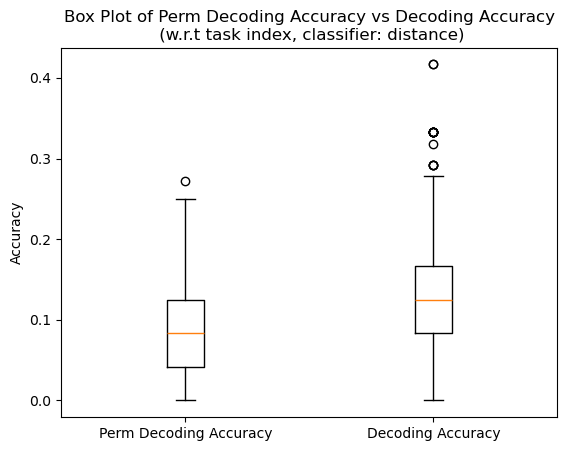

T-test: t-statistic = -8.593535864301947, p-value = 5.239481122766382e-17
Mann-Whitney U test: U-statistic = 42150.0, p-value = 2.5879447892296504e-16


In [40]:
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, mannwhitneyu

plt.boxplot([list(np.mean(encoding_perm_decoding_accuracy, axis = -1)), list(np.mean(encoding_decoding_accuracy, axis = -1))], labels=['Perm Decoding Accuracy', 'Decoding Accuracy'])
plt.ylabel('Accuracy')
plt.title('[encoding phase]Box Plot of Perm Decoding Accuracy vs Decoding Accuracy\n (w.r.t task index, classifier: %s)' % (classifier))
plt.show()

# Perform a t-test
t_stat, p_value = ttest_ind(list(np.mean(encoding_perm_decoding_accuracy, axis = -1)),  list(np.mean(encoding_decoding_accuracy, axis = -1)))
print(f'T-test: t-statistic = {t_stat}, p-value = {p_value}')

# Perform a Mann-Whitney U test
u_stat, p_value = mannwhitneyu(list(np.mean(encoding_perm_decoding_accuracy, axis = -1)),  list(np.mean(encoding_decoding_accuracy, axis = -1)))
print(f'Mann-Whitney U test: U-statistic = {u_stat}, p-value = {p_value}')

Pearson correlation: 0.24326183361571077, p-value: 3.0141818277232676e-06
Spearman correlation: 0.12169248852877924, p-value: 0.020915173025168744


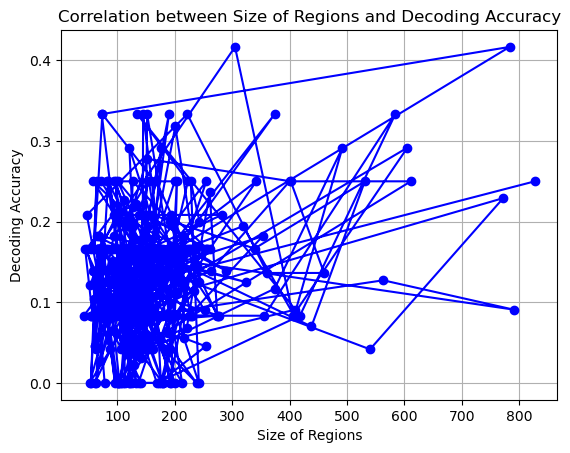

In [41]:
# # sanity check: correlation between n_regions and decoding accuracy
# from scipy.stats import pearsonr, spearmanr
# # Convert lists to numpy arrays
# size_regions = np.array(size_regions)
# decoding_accuracy = np.array(decoding_accuracy)

# # Calculate Pearson and Spearman correlation coefficients
# pearson_corr, pearson_p_value = pearsonr(size_regions, np.mean(decoding_accuracy, axis = -1))
# spearman_corr, spearman_p_value = spearmanr(size_regions, np.mean(decoding_accuracy, axis = -1))

# print(f'Pearson correlation: {pearson_corr}, p-value: {pearson_p_value}')
# print(f'Spearman correlation: {spearman_corr}, p-value: {spearman_p_value}')

# # Create the line plot
# plt.plot(size_regions, np.mean(decoding_accuracy, axis = -1), marker='o', linestyle='-', color='b')
# plt.xlabel('Size of Regions')
# plt.ylabel('Decoding Accuracy')
# plt.title('Correlation between Size of Regions and Decoding Accuracy')
# plt.grid(True)
# plt.show()

In [42]:
task_df[task][sess][run].category.unique()

array([0, 1])

In [43]:
# visualization on brain surfaces
from scipy.stats import binomtest
stats_decoding = np.zeros((num_regions,3,))
unique_stims = np.unique(labels)
# Calculate accuracy and p-values
for region in range(num_regions):
    acc = np.mean(encoding_binary_decoding_accuracy[region])
    p = binomtest(np.sum(encoding_binary_decoding_accuracy[region]), n=len(encoding_binary_decoding_accuracy[region]), p=1/len(unique_stims), alternative = "greater")
    stats_decoding[region, 0] = acc
    stats_decoding[region, 1] = p.pvalue

# Perform FDR correction
q = fdrcorrection(stats_decoding[:, 1])[1]
stats_decoding[:, 2] = q

# Print results
print('Task', task)
print('\tNumber of p<0.05:', np.sum(stats_decoding[:, 1] < 0.05))
print('\tNumber of q<0.05:(after FDR correction)', np.sum(stats_decoding[:, 2] < 0.05))
print('chance:', 1/len(unique_stims))


Task interdmsctgABBA
	Number of p<0.05: 349
	Number of q<0.05:(after FDR correction) 349
chance: 0.08333333333333333


In [44]:
# # identify brain regions that are significantly decodable
# # after fdr correction
# fdr_region_indices = np.where(stats_decoding[:, 2] < 0.05)[0]
# filtered_df = map_df[map_df['region_id'].isin(fdr_region_indices)]
# # Extract the region names
# fdr_region_names = filtered_df['region_name'].tolist()

# # before fdr correction
# region_indices = np.where(stats_decoding[:, 1] < 0.05)[0]
# filtered_df = map_df[map_df['region_id'].isin(region_indices)]
# # Extract the region names
# region_names = filtered_df['region_name'].tolist()

# # Display the result
# # print(region_names)
# # print(fdr_region_names)

['LG', 'V1', 'MST', 'V6', 'V2', 'V3', 'V4', 'V8', 4, '3b', 'FEF', 'PEF', '55b', 'V3A', 'RSC', 'POS2', 'V7', 'IPS1', 'FFC', 'V3B', 'LO1', 'LO2', 'PIT', 'MT', 'PSL', 'SFL', 'PCV', 'STV', '7m', 'POS1', '23d', 'v23ab', 'd23ab', '31pv', '5m', '5mv', '23c', '5L', '24dd', '24dv', '7AL', 'SCEF', '7Am', '7Pl', '7PC', 'LIPv', 'VIP', 'MIP', 1, 2, '3a', '6d', '6mp', '6v', 'p24pr', '33pr', 'a24pr', 'p32pr', 'a24', 'd32', '8BM', 'p32', '10r', '47m', '8Av', '8Ad', '9m', '8BL', '9p', '10d', '8C', 44, 45, '47l', 'a47r', '6r', 'IFJa', 'IFJp', 'IFSp', 'IFSa', 'p9-\n46v', 46, 'a9-\n46v', '9-46d', '9a', '10v', 'a10p', '10pp', '11l', '13l', 'OFC', '47s', 'LIPd', '6a', 'i6-8', 's6-8', 43, 'OP4', 'OP1', 'OP2-3', 52, 'RI', 'PFcm', 'PoI2', 'TA2', 'FOP4', 'MI', 'Pir', 'AVI', 'AAIC', 'FOP1', 'FOP3', 'FOP2', 'PFt', 'AIP', 'EC', 'PreS', 'H', 'ProS', 'PeEc', 'STGa', 'PBelt', 'A5', 'PHA1', 'PHA3', 'STSdp', 'STSvp', 'TGd', 'TE1p', 'TE2a', 'TF', 'TE2p', 'PHT', 'PH', 'TPOJ1', 'TPOJ2', 'TPOJ3', 'DVT', 'PGp', 'IP2', 'IP1'

['LG', 'V1', 'MST', 'V6', 'V2', 'V3', 'V4', 'V8', 4, '3b', 'FEF', 'PEF', '55b', 'V3A', 'RSC', 'POS2', 'V7', 'IPS1', 'FFC', 'V3B', 'LO1', 'LO2', 'PIT', 'MT', 'PSL', 'SFL', 'PCV', 'STV', '7m', 'POS1', '23d', 'v23ab', 'd23ab', '31pv', '5m', '5mv', '23c', '5L', '24dd', '24dv', '7AL', 'SCEF', '7Am', '7Pl', '7PC', 'LIPv', 'VIP', 'MIP', 1, 2, '3a', '6d', '6mp', '6v', 'p24pr', '33pr', 'a24pr', 'p32pr', 'a24', 'd32', '8BM', 'p32', '10r', '47m', '8Av', '8Ad', '9m', '8BL', '9p', '10d', '8C', 44, 45, '47l', 'a47r', '6r', 'IFJa', 'IFJp', 'IFSp', 'IFSa', 'p9-\n46v', 46, 'a9-\n46v', '9-46d', '9a', '10v', 'a10p', '10pp', '11l', '13l', 'OFC', '47s', 'LIPd', '6a', 'i6-8', 's6-8', 43, 'OP4', 'OP1', 'OP2-3', 52, 'RI', 'PFcm', 'PoI2', 'TA2', 'FOP4', 'MI', 'Pir', 'AVI', 'AAIC', 'FOP1', 'FOP3', 'FOP2', 'PFt', 'AIP', 'EC', 'PreS', 'H', 'ProS', 'PeEc', 'STGa', 'PBelt', 'A5', 'PHA1', 'PHA3', 'STSdp', 'STSvp', 'TGd', 'TE1p', 'TE2a', 'TF', 'TE2p', 'PHT', 'PH', 'TPOJ1', 'TPOJ2', 'TPOJ3', 'DVT', 'PGp', 'IP2', 'IP1'

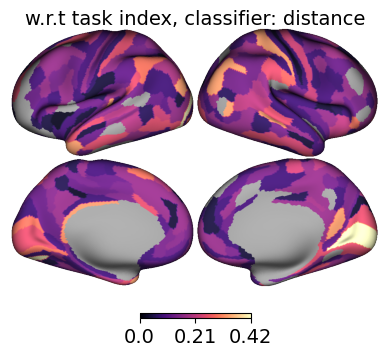

In [45]:
surfaces = fetch_fslr()
lh, rh = surfaces['veryinflated']

surface_dat = np.zeros((len(glasser_atlas),))
for roi in range(num_regions):
    roi_ind = np.where(glasser_atlas==roi+1)[0]
    surface_dat[roi_ind] = stats_decoding[roi,0]
    

p = surfplot.Plot(lh,rh,size=(500,350),zoom=1.8)
p.add_layer(surface_dat.T,cmap='magma',color_range=[np.min(surface_dat), np.max(surface_dat)])
fig = p.build(figsize=(4,4),colorbar=True,cbar_kws={'fontsize':14})
fig.suptitle('w.r.t task index, classifier: %s' % (classifier),y=0.88,fontsize=14)
fig.tight_layout()
# print(region_names)

['LG', 'V1', 'MST', 'V6', 'V2', 'V3', 'V4', 'V8', 4, '3b', 'FEF', 'PEF', '55b', 'V3A', 'RSC', 'POS2', 'V7', 'IPS1', 'FFC', 'V3B', 'LO1', 'LO2', 'PIT', 'MT', 'PSL', 'SFL', 'PCV', 'STV', '7m', 'POS1', '23d', 'v23ab', 'd23ab', '31pv', '5m', '5mv', '23c', '5L', '24dd', '24dv', '7AL', 'SCEF', '7Am', '7Pl', '7PC', 'LIPv', 'VIP', 'MIP', 1, 2, '3a', '6d', '6mp', '6v', 'p24pr', '33pr', 'a24pr', 'p32pr', 'a24', 'd32', '8BM', 'p32', '10r', '47m', '8Av', '8Ad', '9m', '8BL', '9p', '10d', '8C', 44, 45, '47l', 'a47r', '6r', 'IFJa', 'IFJp', 'IFSp', 'IFSa', 'p9-\n46v', 46, 'a9-\n46v', '9-46d', '9a', '10v', 'a10p', '10pp', '11l', '13l', 'OFC', '47s', 'LIPd', '6a', 'i6-8', 's6-8', 43, 'OP4', 'OP1', 'OP2-3', 52, 'RI', 'PFcm', 'PoI2', 'TA2', 'FOP4', 'MI', 'Pir', 'AVI', 'AAIC', 'FOP1', 'FOP3', 'FOP2', 'PFt', 'AIP', 'EC', 'PreS', 'H', 'ProS', 'PeEc', 'STGa', 'PBelt', 'A5', 'PHA1', 'PHA3', 'STSdp', 'STSvp', 'TGd', 'TE1p', 'TE2a', 'TF', 'TE2p', 'PHT', 'PH', 'TPOJ1', 'TPOJ2', 'TPOJ3', 'DVT', 'PGp', 'IP2', 'IP1'

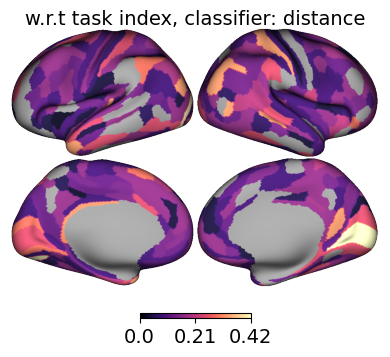

In [46]:
surfaces = fetch_fslr()
lh, rh = surfaces['veryinflated']
surface_dat = np.zeros((len(glasser_atlas),))
for roi in range(num_regions):
    roi_ind = np.where(glasser_atlas==roi+1)[0]
    surface_dat[roi_ind] = stats_decoding[roi,0]*(stats_decoding[roi,1]<0.05)
    all_significant_regions.append(stats_decoding[roi,1]<0.05)


all_significant_regions = np.where(all_significant_regions == np.unique(all_significant_regions)[1])[0]

filtered_df = map_df[map_df['region_id'].isin(all_significant_regions)]
# Extract the region names
fdr_region_names = filtered_df['region_name'].tolist()
p = surfplot.Plot(lh,rh,size=(500,350),zoom=1.8)
p.add_layer(surface_dat.T,cmap='magma',color_range=[np.min(surface_dat), np.max(surface_dat)])
fig = p.build(figsize=(4,4),colorbar=True,cbar_kws={'fontsize':14})
fig.suptitle('w.r.t task index, classifier: %s' % (classifier),y=0.88,fontsize=14)
fig.tight_layout()
print(fdr_region_names)